[16066320.log: 10-03 23:58:43] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:142} DEBUG - Data dir path /data/vision/torralba/dissect/nadiia/adversarial_research/datasets/places/val
[16066320.log: 10-03 23:58:43] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:143} DEBUG - Creating dataset with batch_size 180, num_workers=0
[16066320.log: 10-03 23:58:43] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:79} DEBUG - Creating transformer with crop_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
[16066320.log: 10-03 23:58:43] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:124} DEBUG - Loading dataset from folder /data/vision/torralba/dissect/nadiia/adversarial_research/datasets/places/val


Started...
attempt = 0
*** model resnet18 ***
it 32768


[16066320.log: 10-03 23:58:50] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:142} DEBUG - Data dir path /data/vision/torralba/dissect/nadiia/adversarial_research/datasets/places/val
[16066320.log: 10-03 23:58:50] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:143} DEBUG - Creating dataset with batch_size 180, num_workers=0
[16066320.log: 10-03 23:58:50] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:79} DEBUG - Creating transformer with crop_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
[16066320.log: 10-03 23:58:50] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:124} DEBUG - Loading dataset from folder /data/vision/torralba/dissect/nadiia/adversarial_research/datasets/places/val


Remained 51 imgs, need at least 60
failed!
attempt = 1
*** model resnet18 ***
it 32768
Remained 65 imgs, need at least 60
it 38868
Remained 66 imgs, need at least 60
it 46241
Remained 75 imgs, need at least 60
it 55009
Remained 77 imgs, need at least 60
it 92582
Remained 89 imgs, need at least 60
it 110218
Remained 88 imgs, need at least 60
it 185264
Remained 97 imgs, need at least 60
it 370728
Remained 100 imgs, need at least 60
*** model softresnet18 ***
it 32768
Remained 91 imgs, need at least 60
it 38868
Remained 90 imgs, need at least 60
it 46241
Remained 93 imgs, need at least 60
it 55009
Remained 95 imgs, need at least 60
it 92582
Remained 104 imgs, need at least 60
it 110218
Remained 96 imgs, need at least 60
it 185264
Remained 97 imgs, need at least 60
it 370728


[16066320.log: 10-03 23:59:00] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:221} DEBUG - Loading checkpoint /data/vision/torralba/dissect/nadiia/adversarial_research/checkpoints/long_trained/resnet18/iter_32768_weights.pth


Remained 98 imgs, need at least 60
Batched picked!
Starting attacks...


[16066320.log: 10-03 23:59:01] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:53} DEBUG - Default accuracy 0.5714285373687744
[16066320.log: 10-03 23:59:01] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:58} DEBUG - 
Starting PGD
[16066320.log: 10-03 23:59:01] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:60} DEBUG - Running attack with epsilons=[0.0001, 0.001, 0.01, 0.1]
[16066320.log: 10-03 23:59:20] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:221} DEBUG - Loading checkpoint /data/vision/torralba/dissect/nadiia/adversarial_research/checkpoints/long_trained/resnet18/iter_38868_weights.pth
[16066320.log: 10-03 23:59:20] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:53} DEBUG - Default accuracy 0.5714285373687744
[16066320.log: 10-03 23:59:20] p62132 {/da

[16066320.log: 10-04 00:02:37] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:221} DEBUG - Loading checkpoint /data/vision/torralba/dissect/nadiia/adversarial_research/checkpoints/long_trained/softresnet18/iter_55009_weights.pth
[16066320.log: 10-04 00:02:38] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:53} DEBUG - Default accuracy 0.8265305757522583
[16066320.log: 10-04 00:02:38] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:58} DEBUG - 
Starting PGD
[16066320.log: 10-04 00:02:38] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/adversarial_attacks/test.py:60} DEBUG - Running attack with epsilons=[0.0001, 0.001, 0.01, 0.1]
[16066320.log: 10-04 00:02:57] p62132 {/data/vision/torralba/dissect/nadiia/adversarial_research/utils/util_functions.py:221} DEBUG - Loading checkpoint /data/vision/torralba/dissect/nadiia/adversarial_research/

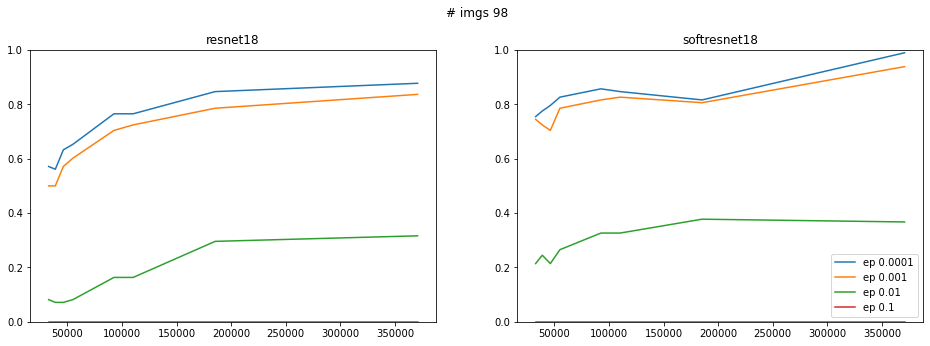

In [6]:
import os
from adversarial_attacks import test
from utils import util_functions as uf
import matplotlib.pyplot as plt
import torch
import argparse
import cv2
print("Started...")

models = [
#    "alexnet", 
    "resnet18", 
#    "softalexnet", 
    "softresnet18"
]

iters = [32768, 38868, 46241, 55009, 92582, 110218, 185264, 370728]
epsilons = [0.0001, 0.001, 0.01, 0.1]

BATCH_SIZE = 180
MIN_EXAMPLES = 60
train_len = "long"
iter_prefix = "best_iter"

pos = len(iter_prefix.split("_"))

def list_dirs(_model):
    p = "checkpoints/{}_trained/{}".format(train_len, _model)
    ll = [x for x in os.listdir(p) if iter_prefix in x]
    ll = [int(x.split("_")[pos]) for x in ll]
    ll = sorted(ll)
    return ll

def get_image_both_sizes(dataset="places", val=True):
    image_batch, labels, orig_paths, names, \
    cats, orig_images, catlist = test.get_batch("resnet18",
                                                batch_size=BATCH_SIZE)
    paths = orig_paths[0]
    base = uf.find_child_dir_path("datasets")
    basepath_val = os.path.join(base, dataset, "val")
    basepath_train = os.path.join(base, dataset, "train")
    image_batch_alex, labels_alex, paths = \
        uf.get_image_as_batch(paths=tuple(paths),
                              val_data_folder=basepath_val,
                              train_data_fold=basepath_train,
                              val=val, model="alexnet",
                              batch_size=BATCH_SIZE)
    image_batch_alex, labels_alex = image_batch_alex.cuda(), labels_alex.cuda()
    lbls_sorted, _ = torch.sort(labels)
    lbls_alex_sorted, _ = torch.sort(labels_alex)
    assert torch.equal(lbls_sorted, lbls_alex_sorted)
    return image_batch_alex, image_batch, labels, orig_paths


image_batch_alex, image_batch, labels, orig_paths = None, None, None, None
attempt = 0
correct_imgs = -1
#find image that is classified correctly for all models and iters
while attempt < 50:
    print("attempt = {}".format(attempt))
    image_batch_alex_attempt, image_batch_attempt, labels_attempt, orig_paths_attempt = get_image_both_sizes()
    attempt += 1
    failed = False
    for mod in models:
        
        #if one model failed, dont try others
        if failed is True:
            break
            
        print("*** model {} ***".format(mod))
        for it in iters:
            print("it {}".format(it))
            
            model = uf.get_model_arg(mod, it, longtrain=train_len=="long")
            model.eval()
            model.cuda()
            batch = image_batch_alex_attempt if "alex" in mod else image_batch_attempt
            assert batch.shape[0] == BATCH_SIZE
            out = model(batch.cuda())
            predcat = torch.argmax(out, dim=1)
            correct_imgs = torch.flatten(torch.nonzero(predcat == labels_attempt))
            batch = batch[correct_imgs]
            labels = labels_attempt[correct_imgs]

            if "alex" in mod:
                image_batch_alex = batch
            else:
                image_batch = batch
                
            print("Remained {} imgs, need at least {}".format(
                len(correct_imgs), MIN_EXAMPLES))

            if len(correct_imgs) < MIN_EXAMPLES:
                print("failed!")
                failed = True
                break
    
    #if all models passed keep the batch
    if failed is False:
        break


if not len(correct_imgs) == image_batch.shape[0]:
    print("len(correct_imgs)={} == image_batch.shape[0]={} == image_batch_alex.shape[0]={}".format(
        len(correct_imgs), image_batch.shape[0], image_batch_alex.shape[0]))
print("Batched picked!")

if attempt >= 50:
    print("Didn't find an image with correct classification!")
    exit()

rows = 1
cols = 2
figsize = (cols * 8, rows * 5)
fig, axs = plt.subplots(rows, cols, figsize=figsize)
mid = (fig.subplotpars.right + fig.subplotpars.left) / 2
plt.subplots_adjust(left=None, bottom=None, right=None, 
                    #top=1,
                    wspace=None, hspace=None)
plt.suptitle("# imgs {}".format(len(correct_imgs)), x=mid, y=1)

print("Starting attacks...")

for i, mod in enumerate(models):
    accs = []
    ax = axs[i]
    for it in iters:
        epsilons, robust_accuracy, raw, clipped, \
            is_adv, (predcat, adv_predcat, label) = test.run_attacks(mod, it,
                image_batch if "alexnet" not in mod else image_batch_alex,
                labels, attack_name="PGD", longtrain=train_len=="long",
                epsilons=epsilons)

        accs.append(robust_accuracy)

    ax.set_title(mod)
    for j, ep in enumerate(epsilons):
        ax.plot(iters, [x[j] for x in accs], label="ep {}".format(ep))
        ax.set_ylim([0, 1])
#plt.ylim(top=1.0)
plt.legend()
plt.show()
plt.close()


In [2]:
ll1 = list_dirs("softresnet18")
ll2 = list_dirs("softalexnet")
ll3 = list_dirs("alexnet")
ll4 = list_dirs("resnet18")
print(ll3)
print(ll4)
mi = min([
    # ll1[-1],
    # ll2[-1],
    ll3[-1],
    ll4[-1]
])
print(mi)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/long_trained/alexnet'